<a href="https://colab.research.google.com/github/Hassan6678/Machine-Learning/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.6 MB/s eta 0:00:00


In [2]:
from datasets import list_datasets, load_dataset
import pandas as pd, numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

In [3]:
all_datasets = list_datasets()
len(all_datasets),all_datasets[:10]

<ipython-input-3-498c39ff4daa>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


(46391,
 ['acronym_identification',
  'ade_corpus_v2',
  'adversarial_qa',
  'aeslc',
  'afrikaans_ner_corpus',
  'ag_news',
  'ai2_arc',
  'air_dialogue',
  'ajgt_twitter_ar',
  'allegro_reviews'])

In [4]:
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']

In [7]:
train_ds[10]

{'text': 'i feel like i have to make the suffering i m seeing mean something',
 'label': 0}

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
emotions.set_format(type="pandas")

In [10]:
df = emotions['train'][:]
df.sample(5)

,text,label
323,i stopped feeling so exhausted a href http pro...,0
9618,i feel you i dont believ in you but i keep my ...,1
12253,my flatmate was asking questions about my rela...,3
2872,i feel crazily indecisive impulsive just in a,4
10597,i had been feeling was all my fault that i had...,3


In [11]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


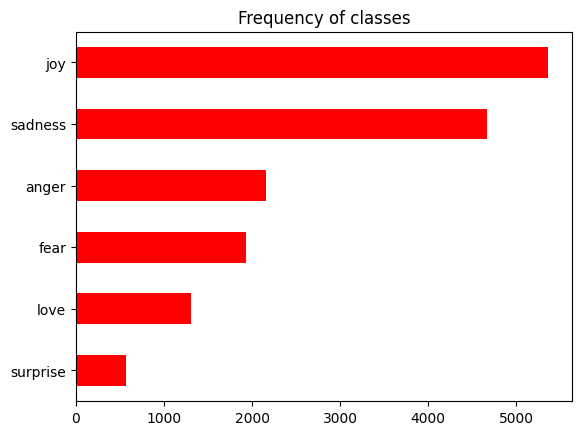

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh(color='red')
plt.title("Frequency of classes")
plt.show()

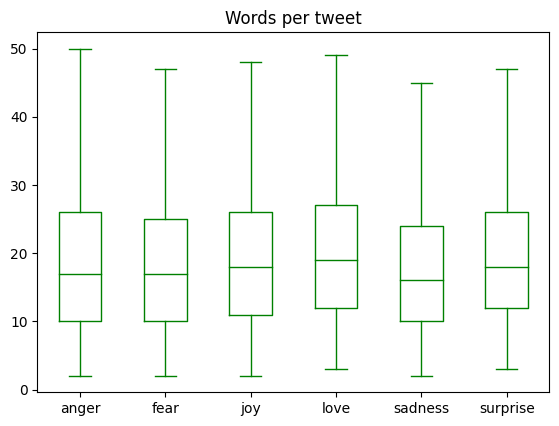

In [13]:
df['Words per tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False,showfliers=False, color="green")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
""" Most Tweets around 15 words long """

' Most Tweets around 15 words long '

In [15]:
# Now we don't need dataset anymore.
emotions.reset_format()

In [16]:
text = "Tokenizing text a is a core part of NLP"
tokenized_text = text.split()
tokenized_text

['Tokenizing', 'text', 'a', 'is', 'a', 'core', 'part', 'of', 'NLP']

In [17]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 1037, 2003, 1037, 4563, 2112, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'a',
 'is',
 'a',
 'core',
 'part',
 'of',
 'nl',
 '##p',
 '[SEP]']

In [20]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text a is a core part of nlp [SEP]'

In [21]:
def tokenize(batch):
  return tokenizer(batch['text'],padding=True,truncation=True)

In [22]:
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [23]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
emotions_encoded['test'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [25]:
tokens = tokenizer.convert_ids_to_tokens(emotions_encoded['train']['input_ids'][0])
tokenizer.convert_tokens_to_string(tokens)

'[CLS] i didnt feel humiliated [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
text = "Hassan Raza"
inputs = tokenizer(text,return_tensors='pt')
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.2588,  0.0749, -0.1270,  ..., -0.1123,  0.2678,  0.1813],
         [ 0.3759,  0.1632, -0.2006,  ..., -0.4264,  0.2830, -0.5040],
         [ 0.1826,  0.1516, -0.5216,  ..., -0.5919,  0.5577, -0.4601],
         [-0.3128, -0.2297, -0.7011,  ..., -0.6360,  0.4651, -0.4087],
         [ 0.7900,  0.1026, -0.5698,  ...,  0.2190, -0.6034, -0.3150]]]), hidden_states=None, attentions=None)

In [29]:
# outputs.last_hidden_state[:,0].cpu().numpy()
inputs

{'input_ids': tensor([[  101, 13222, 10958,  4143,   102]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [30]:
import numpy
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_stat": last_hidden_state[:,0].cpu().numpy()}

In [31]:
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])

In [32]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_stat"])
X_valid = np.array(emotions_hidden["validation"]["hidden_stat"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [35]:
from sklearn.linear_model import LogisticRegression

# We Increase 'max_iter' to gurantee converage
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.634

In [36]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

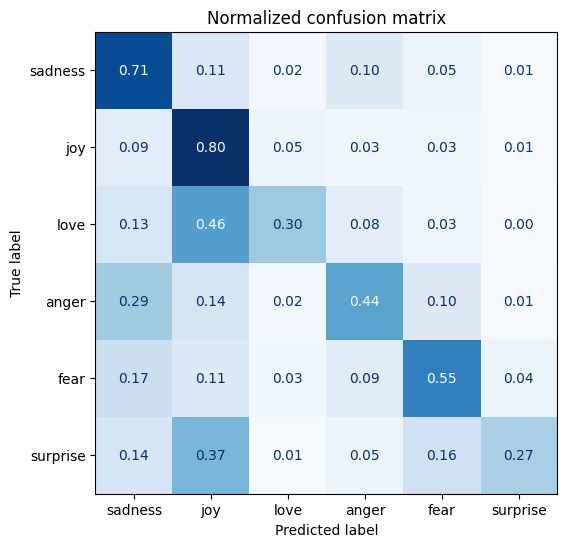

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)